In [2]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import mysql.connector

In [3]:
# establishing connection with sql database
db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password ="Adity@9004",
                             database = "ecommerce" )
# activate the cursor
cur = db.cursor()

###  List all unique cities where customers are located.


In [4]:
query = """ select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


### Count the number of orders placed in 2017.

In [5]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
print(f"Total orders placed in 2017 are {data[0][0]}")

Total orders placed in 2017 are 45101


### Find the total sales per category.

In [6]:
query = """ select upper(products.product_category) as category,
            round(sum(payments.payment_value),2) as sales
            from products join order_items
            on products.product_id = order_items.product_id 
            join payments
            on payments.order_id = order_items.order_id
            group by category;
             """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Categories", "Sales"])
df.head()

,Categories,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33


### Calculate the percentage of orders that were paid in installments.

In [7]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100    
            from payments"""
cur.execute(query)
data = cur.fetchall()
# print(f"Total orders placed in 2017 are {data[0][0]}")
print(f"The percentage of orders that were paid in installments is {data[0][0]}")

The percentage of orders that were paid in installments is 99.9981


### Count the number of customers from each state. 

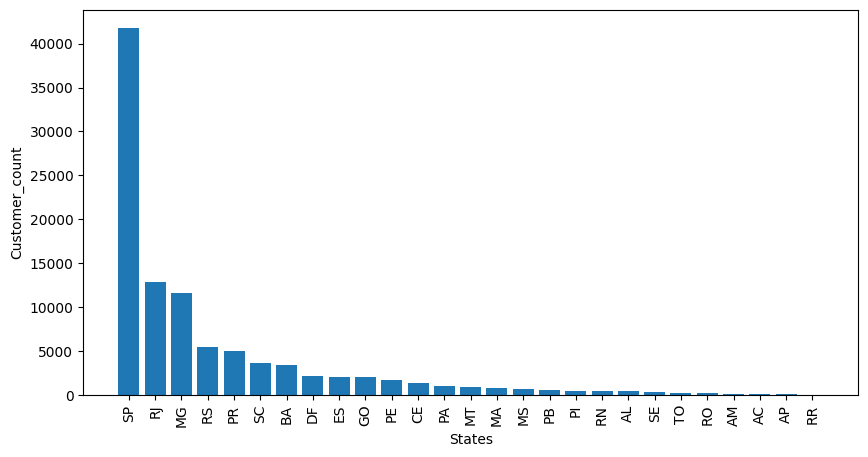

In [8]:
query = """ select customer_state,count(customer_id)
            from customers
            group by customer_state"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns = ["States", "Customer_count"])
df = df.sort_values(by = "Customer_count",ascending = False)

plt.figure(figsize = (10,5))
plt.bar(df["States"],df["Customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("States")
plt.ylabel("Customer_count")
plt.show()

###  Calculate the number of orders per month in 2018.

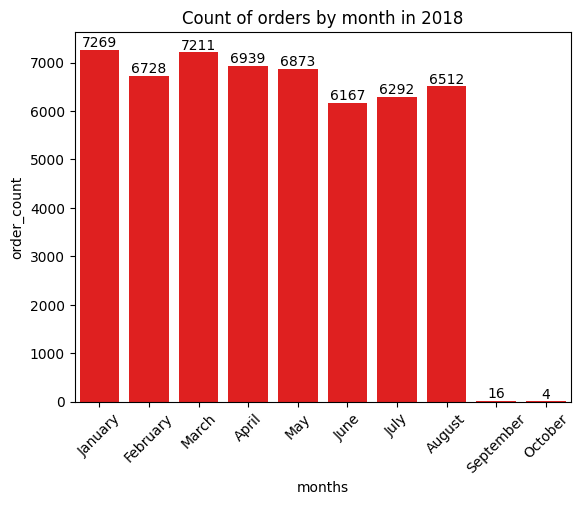

In [9]:
query = """select monthname(order_purchase_timestamp) as monthname, count(order_id) as Total_Orders
           from orders 
           where year(order_purchase_timestamp) = 2018
           group by monthname;"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["months","order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x=df["months"], y =df["order_count"],data=df,order=o ,color="red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of orders by month in 2018")
plt.show()

###  Find the average number of products per order, grouped by customer city.

In [10]:
query = """ with count_per_order as
        (
            select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
            from orders
            join order_items
            on orders.order_id = order_items.order_id
            group by orders.order_id, orders.customer_id
        )           
            select upper(customers.customer_city), round(avg(count_per_order.oc),2) as average_order
            from customers
            join count_per_order
            on customers.customer_id = count_per_order.customer_id
            group by customers.customer_city
            order by average_order desc;

        """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer City", "Average products per order "])
df.head()

,Customer City,Average products per order
0,PADRE CARVALHO,7.00
1,CELSO RAMOS,6.50
2,DATAS,6.00
3,CANDIDO GODOI,6.00
4,MATIAS OLIMPIO,5.00


###  Calculate the percentage of total revenue contributed by each product category.

In [11]:
query = """ select products.product_category as category,
round(sum(payments.payment_value)/(select sum(payment_value) from payments)*100,2) as avg
from products join order_items
on products.product_id = order_items.product_id
join  payments
on order_items.order_id = payments.order_id
group by category;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "% of total revenue"])
df.head()

,Category,% of total revenue
0,perfumery,3.17
1,Furniture Decoration,8.93
2,telephony,3.04
3,bed table bath,10.70
4,automotive,5.32


###  Identify the correlation between product price and the number of times a product has been purchased.

In [12]:
query = """ select products.product_category as category,
count(order_items.product_id) as count,
round(avg(order_items.price),2) Price
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ["Category","Order Count", "Price"])
df.head()

,Category,Order Count,Price
0,HEALTH BEAUTY,9670,130.16
1,sport leisure,8641,114.34
2,Cool Stuff,3796,167.36
3,computer accessories,7827,116.51
4,Watches present,5991,201.14


In [13]:
import numpy as np 
arr1 =df["Order Count"]
arr2 = df['Price']

a =np.corrcoef(arr1,arr2)
print(f"The correlation coefficient is {a[0][1]}")

The correlation coefficient is -0.10631514167157562


Since this value is close to 0 as compared to -1(which signify inverse relation), we can conclude that order count and price has no correlation

### Calculate the total revenue generated by each seller, and rank them by revenue.

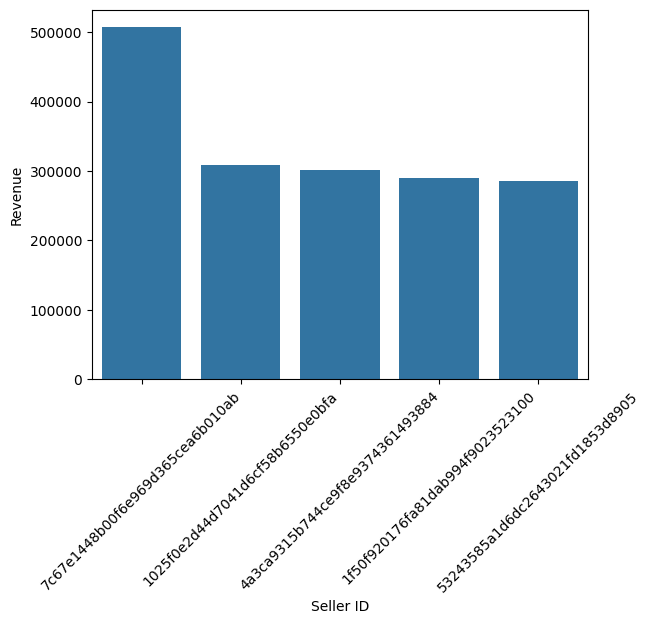

In [14]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id , round(sum(payments.payment_value),2) as revenue
from order_items join payments 
on payments.order_id = order_items.order_id
group by order_items.seller_id ) as a	

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ["Seller ID","Revenue", "Rank"])
sns.barplot(x='Seller ID' , y="Revenue" ,data=df.head())
plt.xticks(rotation = 45  )
plt.show()